<a href="https://colab.research.google.com/github/trodrigue1304/Fraud_detection_algorithm/blob/Med/source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Chargement des données et paramétrage de l'environnement de travail**

In [55]:
# Chargement des packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import sklearn as skl
import seaborn as sns
from google.colab import drive
from sklearn.impute import KNNImputer

# Connexion à google drive et importation des données
drive.mount('/content/drive')
id_train=pd.read_csv('/content/drive/My Drive/projet python/train_identity.csv')
tr_train=pd.read_csv('/content/drive/My Drive/projet python/train_transaction.csv')
id_test=pd.read_csv('/content/drive/My Drive/projet python/test_identity.csv')
tr_test=pd.read_csv('/content/drive/My Drive/projet python/test_transaction.csv')

## Affichage de toutes les lignes pour les outputs
pd.options.display.max_rows = 4000

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Première exploration des données**

**Visualisation des données**

In [56]:
id_train.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,18.0,529.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,15.0,352.0,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,484.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [57]:
tr_train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,debit,272.0,87.0,36.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,debit,126.0,87.0,0.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,NaN,NaN,mail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,debit,337.0,87.0,NaN,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,debit,204.0,87.0,19.0,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,12.0,2.0,61.0,61.0,30.0,318.0,30.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,495.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
#verifier que toutes les TransactionID de id_train existe dans tr_train
print("Taille de la base identity : ",id_train.shape)
print("Taille de la base transaction : ",tr_train.shape)
print("Nombre de transactions uniques de la base transaction : ",id_train['TransactionID'].nunique())
print("Nombre de transactions uniques de la base identity : ",tr_train['TransactionID'].nunique())
print("Proportion de transactions avec id information (train): "+"{:.2%}".format(np.sum(tr_train['TransactionID'].isin(id_train['TransactionID'].unique()))/tr_train['TransactionID'].nunique()))
print("Proportion de transactions avec id information (test): "+"{:.2%}".format(np.sum(tr_test['TransactionID'].isin(id_test['TransactionID'].unique()))/tr_test['TransactionID'].nunique()))

Taille de la base identity :  (144233, 41)
Taille de la base transaction :  (590540, 394)
Nombre de transactions uniques de la base transaction :  144233
Nombre de transactions uniques de la base identity :  590540
Proportion de transactions avec id information (train): 24.42%
Proportion de transactions avec id information (test): 28.01%


On remarque qu'il y a des transactions sans informations d'identification. On ne tiendra pas compte de ces données.

**Fusion des bases de données**

In [59]:
train=pd.merge(tr_train,id_train,on="TransactionID",how="right")
test=pd.merge(tr_test,id_test,on="TransactionID",how="right")

**Type des variables**

In [60]:
train.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
C14               float64
D1                float64
D2                float64
D3                float64
D4                float64
D5                float64
D6                float64
D7                float64
D8          

**Détection des valeurs manquantes**

In [61]:
missing_data=train.isnull().sum().sum()
total_data=np.product(train.shape)
print("Proportion de données manquantes dans la base : "+"{:.2%}".format(missing_data/total_data))

Proportion de données manquantes dans la base : 26.89%


In [62]:
#Fonction pour la visualition de la répartition des données manquantes
def missing_view(data) :
  null_counts = data.isnull().sum()/len(data)
  plt.figure(figsize=(100,20))
  plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
  plt.ylabel('Proportion de données manquantes')
  plt.bar(np.arange(len(null_counts)),null_counts)


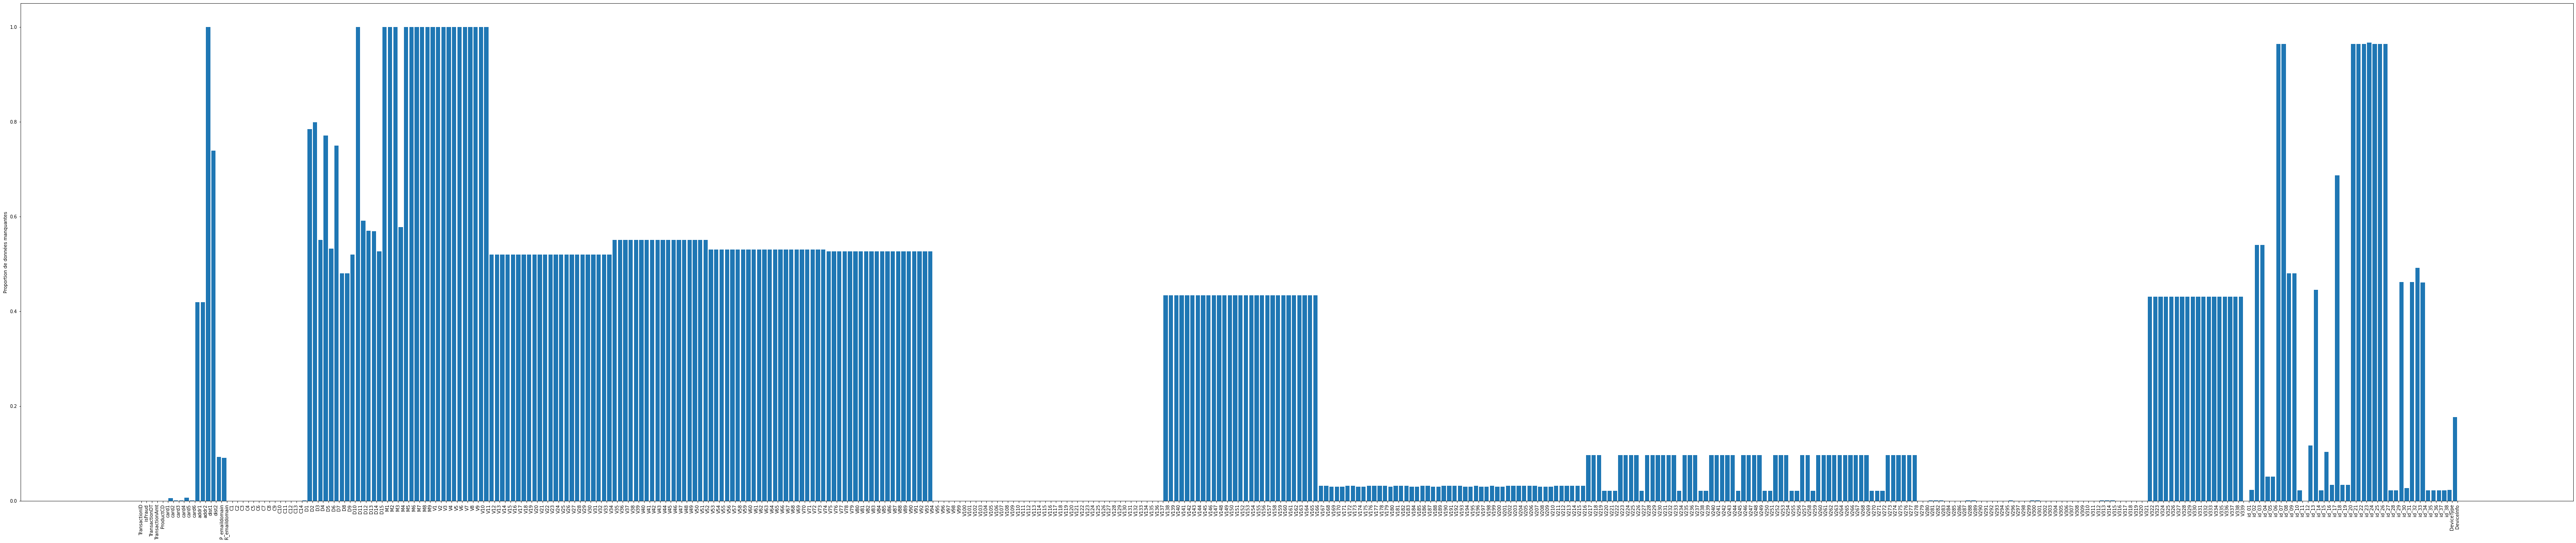

In [63]:
#Visualisation
missing_view(train)

Il faudra donc procéder à un traitement des valeurs manquantes et s'il le faut voir l'impact sur les modèles futurs.

**Analyse de la variable d'intérêt**

In [64]:
#Tableau des effectifs
tab = pd.DataFrame(train.groupby('isFraud').count()['TransactionID'])
tab

,TransactionID
isFraud,
0,132915
1,11318


Text(0.5, 1.0, 'Distribution de la variable isFraud')

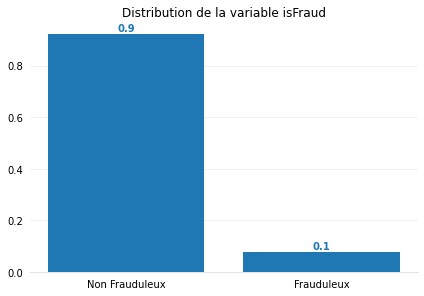

In [65]:
#Visualisation
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Grab the color of the bars so we can make the
# text the same color.
bar_color = bars[0].get_facecolor()

# Add text annotations to the top of the bars.
# Note, you'll have to adjust this slightly (the 0.3)
# with different data.
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.01,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

fig.tight_layout()

ax.set_title("Distribution de la variable isFraud")

  On soupçonne un surapprentissage des modèles sur les valeurs non frauduleuses. On recalibre les données de manière à avoir une répartition uniforme.

In [66]:
#Recalibrage
class0=np.where(train['isFraud']==0)[0]
class1=np.where(train['isFraud']==1)[0]
class0_downsample=np.random.choice(class0,size=len(class1),replace=False)
Kept_index=sorted([*class0_downsample,*class1])
train_calibrate=train[train.index.isin(Kept_index)]

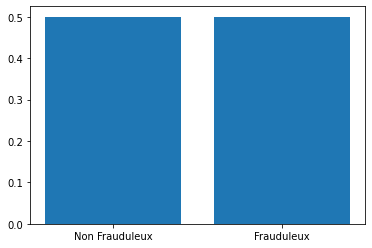

In [67]:
#On s'assure que le tirage a été bien fait
tab = pd.DataFrame(train_calibrate.groupby('isFraud').count()['TransactionID'])
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

**Visualisation des données manquantes dans la base recalibré**

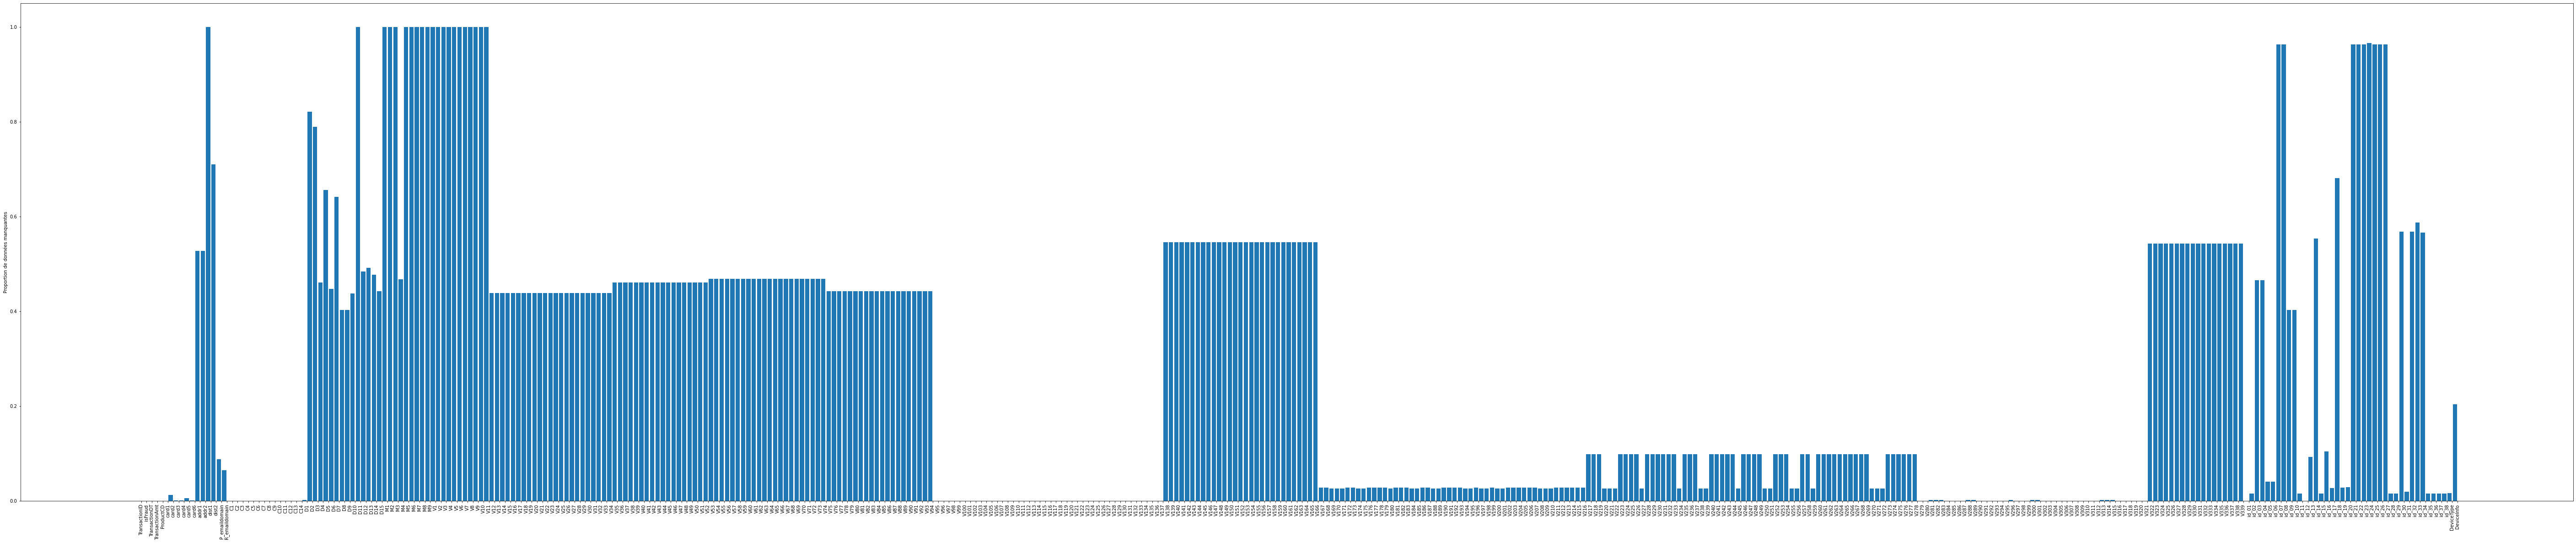

In [68]:
missing_view(train_calibrate)

On remarque que la distribution est quasiment la même avec celle obtenue avant. 
Conclusion : Les données recalibrées sont à l'image des données initiale sur ce plan. On peut donc se restreindre à la nouvelle base pour la suite des travaux.

### **Analyse et traitement des données manquantes**

**Valeurs manquantes suivant la variable d'intérêt**

Text(0.5, 0.98, 'Valeurs manquantes sur les données frauduleuses')

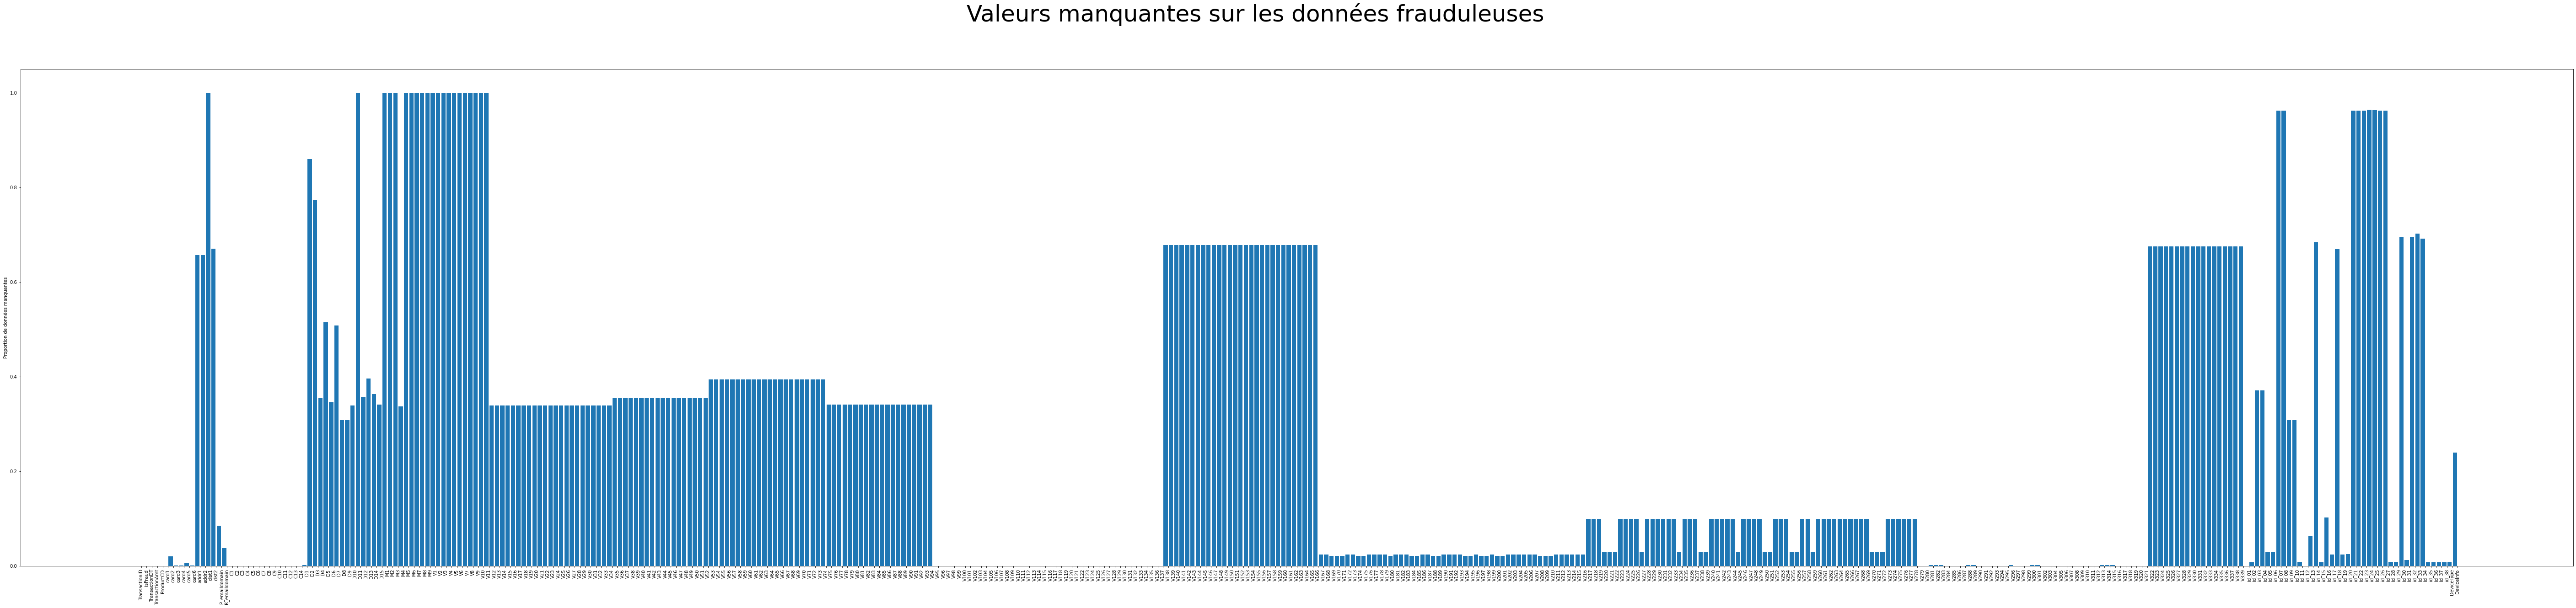

In [69]:
missing_view(train_calibrate[train_calibrate.isFraud == 1])
plt.suptitle("Valeurs manquantes sur les données frauduleuses", fontsize=50)

Text(0.5, 0.98, 'Valeurs manquantes sur les données non frauduleuses')

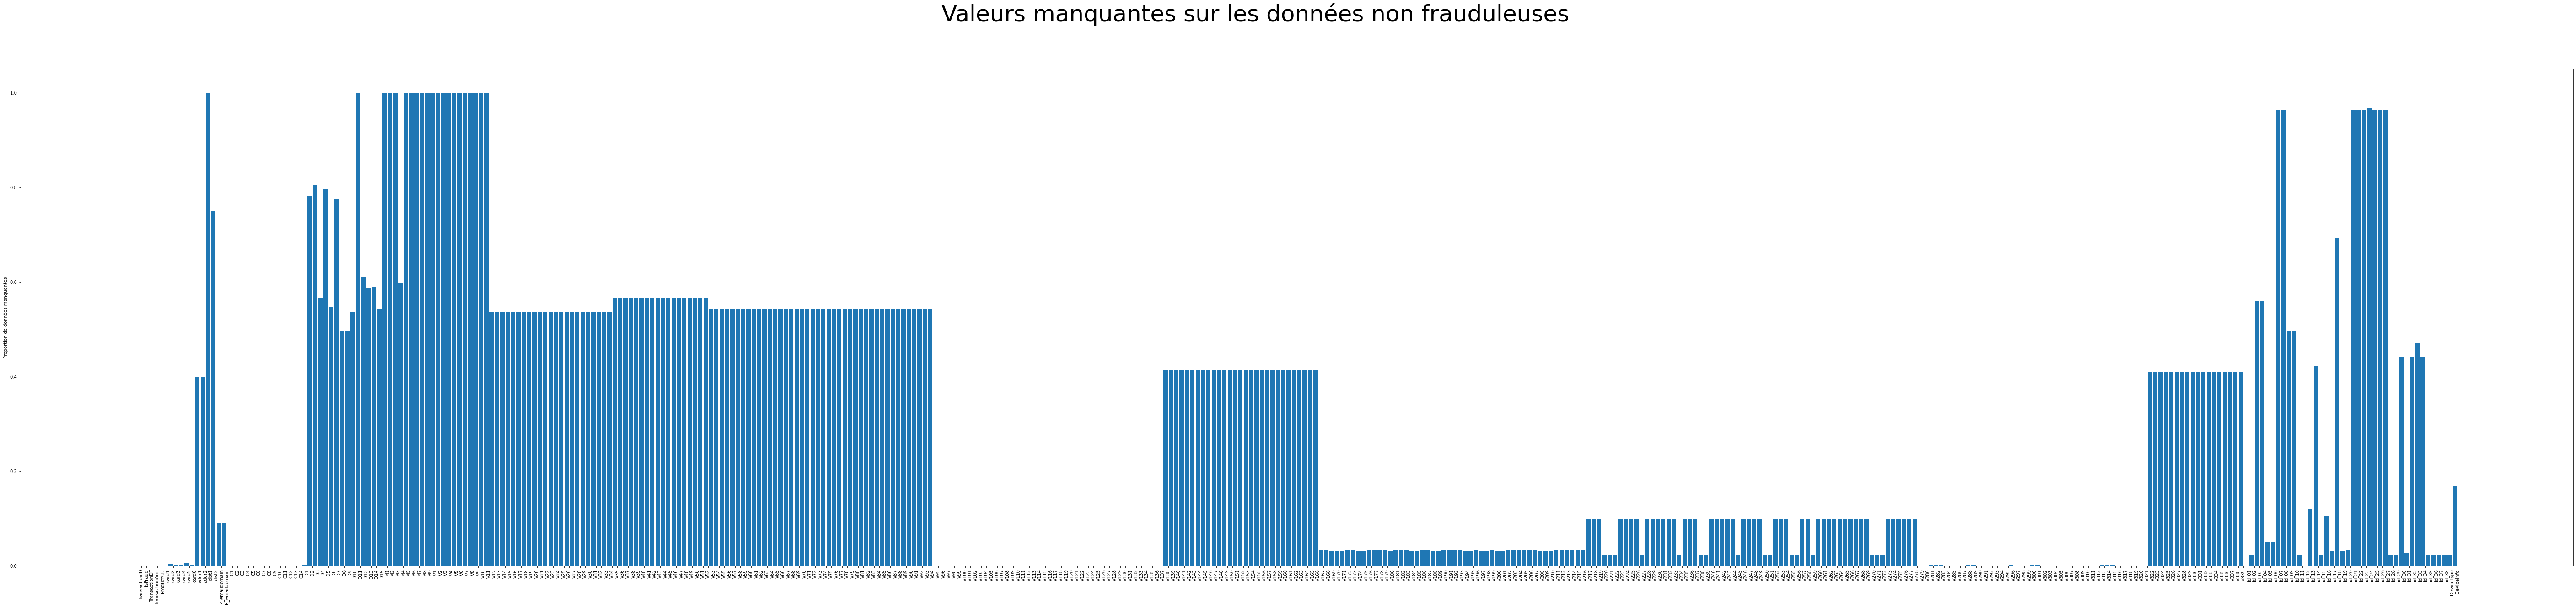

In [70]:
missing_view(train_calibrate[train_calibrate.isFraud == 0])
plt.suptitle("Valeurs manquantes sur les données non frauduleuses", fontsize=50)

De manière générale, on remarque que la représentation est pratiquement la même. On peut dès lors faire une courbe de sensibilité pour voir le nombre de variables par seuil.

**Courbe de sensibilité**

In [71]:
train_column_miss = train_calibrate.isnull().any()
print(f'Nombre de variables avec des données manquantes (apprentissage) : {train_column_miss.sum()} .')

Nombre de variables avec des données manquantes (apprentissage) : 412 .


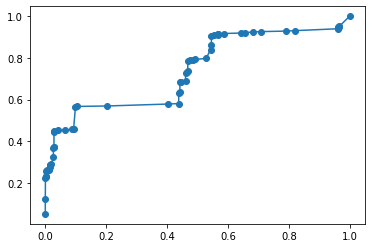

In [72]:
column_miss = train_calibrate.isnull().sum()/train_calibrate.shape[0]
my_series = pd.Series(np.sort(column_miss.values))
sensibility_graph = my_series.value_counts().reset_index().sort_values(by=['index'])
sensibility_graph[0] = np.cumsum(sensibility_graph[0]/sensibility_graph[0].sum())
plt.plot(sensibility_graph['index'], sensibility_graph[0], '-o')

On peut essayer de voir ce qui se passe à partir de 60 % de données manquantes.

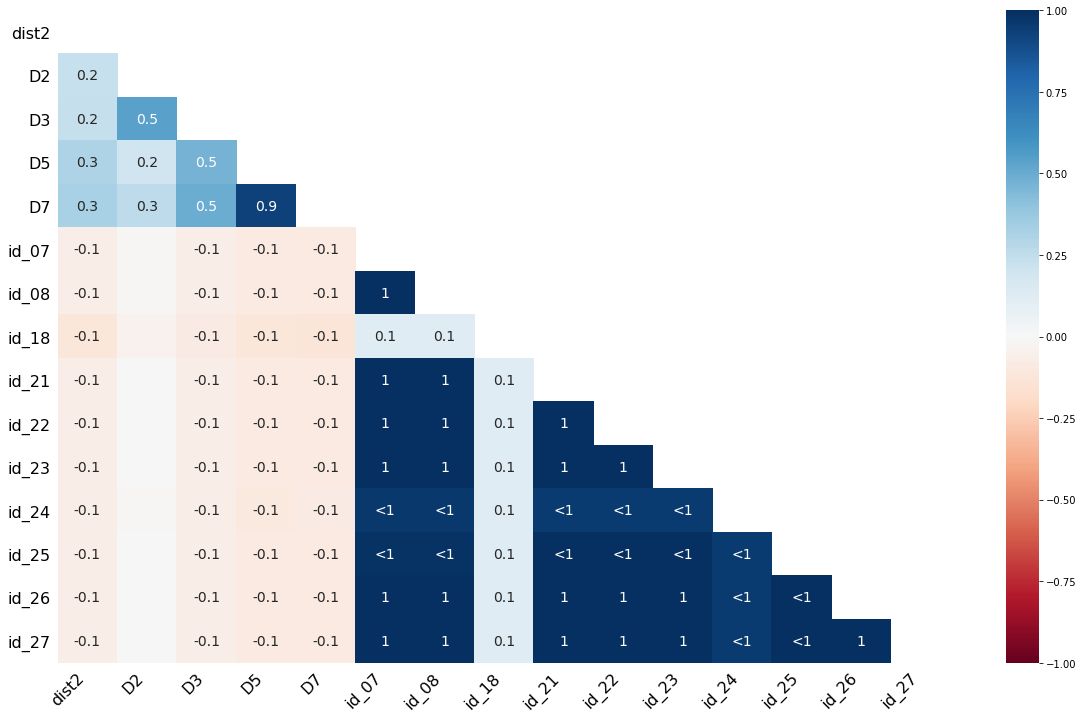

In [73]:
null_counts = train_calibrate.isnull().sum()/len(train_calibrate)
train_data_miss_60 = train_calibrate.filter(items=null_counts[null_counts>=0.6].reset_index()['index'])
msno.heatmap(train_data_miss_60)

On remarque que pour plusieurs des variables, elles prennent conjointement les valeurs manquantes. Couplé au fait que l'apparition des données manquantes est relativement indépendant du caractère frauduleux de la variable, on peut se restreindre aux variables de moins de 60% de valeurs manquantes. De plus, la courbe de sensibilité nous incite à abaisser ce taux à 20% puisqu'il n'y a pas énormément de variables entre 20 et 40%. Une analyse comparative des résultats pourra être ajoutée suivant le seuil choisi.

**Traitement des valeurs manquantes**

In [74]:
###On décide de ne retenir que les variables de moins de 20% de données manquantes et de procéder à une imputation par KNN 
train_work = train_calibrate.filter(items=null_counts[null_counts<0.2].reset_index()['index'])
train_work.shape

(22636, 246)

In [75]:
from sklearn.impute import KNNImputer
train_imputed = KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(train_work.select_dtypes(exclude='object'))

In [76]:
train_imputed

array([[2.9871000e+06, 0.0000000e+00, 8.8169000e+04, ..., 1.6600000e+02,
        2.1500000e+02, 5.3300000e+02],
       [2.9871010e+06, 0.0000000e+00, 8.8174000e+04, ..., 1.6600000e+02,
        1.0000000e+02, 5.3500000e+02],
       [2.9871210e+06, 0.0000000e+00, 8.8517000e+04, ..., 1.6600000e+02,
        2.1500000e+02, 2.7700000e+02],
       ...,
       [3.5774760e+06, 0.0000000e+00, 1.5809901e+07, ..., 2.2500000e+02,
        4.2700000e+02, 5.9500000e+02],
       [3.5774950e+06, 0.0000000e+00, 1.5810221e+07, ..., 1.6600000e+02,
        2.1500000e+02, 2.6600000e+02],
       [3.5775260e+06, 1.0000000e+00, 1.5810876e+07, ..., 1.6600000e+02,
        3.5200000e+02, 3.3300000e+02]])

In [77]:
train_imputed = pd.DataFrame(train_imputed)
train_imputed.columns = train_work.select_dtypes(exclude='object').columns
train_imputed = pd.merge(train_imputed,train_work[np.append('TransactionID',train_work.select_dtypes('object').columns.values)],on="TransactionID",how="left")
train_imputed


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,...,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,ProductCD,card4,card6,P_emaildomain,R_emaildomain,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
0,2987100.0,0.0,88169.0,100.000,16659.0,170.0,150.0,226.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,264818.0,0.0,0.0,100.0,36.8,166.0,215.0,533.0,H,visa,credit,comcast.net,NaN,NotFound,New,NotFound,New,NotFound,chrome 62.0 for android,T,F,T,T,mobile
1,2987101.0,0.0,88174.0,25.000,4523.0,423.0,150.0,226.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49557.0,0.0,0.0,100.0,47.8,166.0,100.0,535.0,H,visa,debit,yahoo.com,NaN,NotFound,Found,Found,Found,Found,chrome 49.0,T,T,T,T,desktop
2,2987121.0,0.0,88517.0,50.000,1804.0,161.0,150.0,117.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18305.0,2.0,0.0,100.0,40.2,166.0,215.0,277.0,H,mastercard,debit,gmail.com,NaN,NotFound,Found,Found,Found,Found,chrome 62.0,T,F,T,T,desktop
3,2987148.0,0.0,88842.0,30.000,14858.0,558.0,150.0,226.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,123916.0,0.0,0.0,100.0,49.0,166.0,390.0,549.0,H,visa,debit,yahoo.com,NaN,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,F,T,mobile
4,2987240.0,1.0,90193.0,37.098,13413.0,103.0,185.0,137.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,169947.0,3.0,0.0,100.0,38.0,225.0,266.0,325.0,C,visa,credit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 54.0 for android,F,F,T,T,mobile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22631,3577368.0,1.0,15807677.0,100.000,6758.0,399.0,150.0,146.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,23.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,214747.0,0.0,0.0,100.0,27.0,166.0,492.0,225.0,H,american express,credit,hotmail.com,hotmail.com,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,F,T,mobile
22632,3577397.0,0.0,15808209.0,16.108,5812.0,408.0,185.0,224.0,5.0,11.0,0.0,3.0,0.0,3.0,3.0,3.0,0.0,8.0,4.0,4.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,313942.0,0.0,0.0,100.0,52.0,225.0,266.0,315.0,C,mastercard,debit,gmail.com,gmail.com,NotFound,Found,Found,Found,Found,chrome 66.0,F,F,T,F,desktop
22633,3577476.0,0.0,15809901.0,58.512,3154.0,408.0,185.0,224.0,2.0,13.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10.0,81665.0,0.0,0.0,100.0,52.0,225.0,427.0,595.0,C,mastercard,debit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 65.

**categorical features**

C    12292
R     4525
H     4227
S     1592
Name: ProductCD, dtype: int64


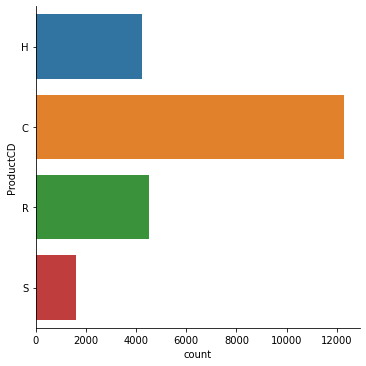

In [78]:
print(train_imputed['ProductCD'].value_counts(dropna=False))
sns.catplot(y='ProductCD',kind='count',data=train_imputed)
  

visa                13960
mastercard           7360
american express      942
discover              342
NaN                    32
Name: card4, dtype: int64


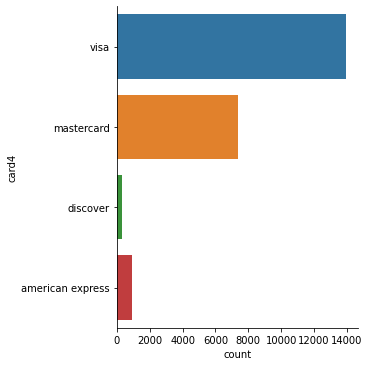

In [79]:
print(train_imputed['card4'].value_counts(dropna=False))
sns.catplot(y='card4',kind='count',data=train_imputed)

credit         12584
debit          10020
NaN               29
charge card        3
Name: card6, dtype: int64


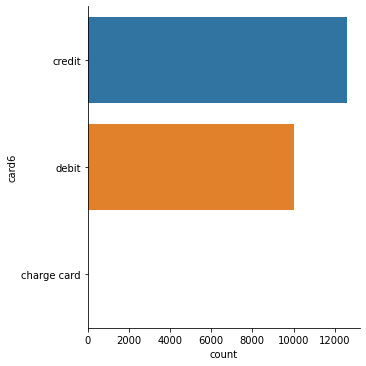

In [80]:
print(train_imputed['card6'].value_counts(dropna=False))
sns.catplot(y='card6',kind='count',data=train_imputed)

gmail.com           10342
hotmail.com          4079
anonymous.com        2078
NaN                  1991
yahoo.com            1447
outlook.com           592
aol.com               452
comcast.net           226
icloud.com            166
yahoo.com.mx          121
msn.com               102
live.com               88
live.com.mx            81
outlook.es             79
verizon.net            74
sbcglobal.net          71
me.com                 58
bellsouth.net          56
att.net                50
mail.com               47
cox.net                42
hotmail.es             42
ymail.com              36
mac.com                32
protonmail.com         29
optonline.net          27
web.de                 26
hotmail.fr             25
gmx.de                 18
charter.net            17
earthlink.net          16
prodigy.net.mx         16
yahoo.fr               16
yahoo.de                9
suddenlink.net          8
hotmail.co.uk           8
frontier.com            6
gmail                   6
embarqmail.c

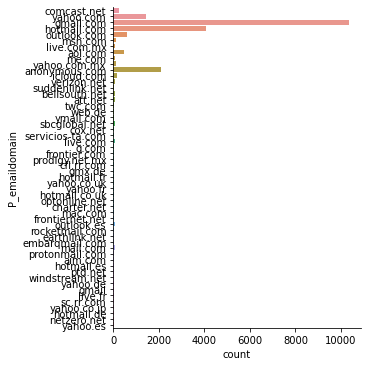

In [81]:
print(train_imputed['P_emaildomain'].value_counts(dropna=False))
sns.catplot(y='P_emaildomain',kind='count',data=train_imputed)

gmail.com           10768
hotmail.com          3988
anonymous.com        2175
yahoo.com            1571
NaN                  1472
outlook.com           586
aol.com               447
icloud.com            279
comcast.net           180
yahoo.com.mx          121
live.com              100
live.com.mx            85
outlook.es             79
msn.com                69
verizon.net            58
cox.net                57
me.com                 51
mail.com               50
sbcglobal.net          44
att.net                42
hotmail.es             42
protonmail.com         39
bellsouth.net          32
ymail.com              27
hotmail.fr             26
web.de                 26
mac.com                24
charter.net            22
gmx.de                 18
optonline.net          16
yahoo.fr               16
prodigy.net.mx         16
rocketmail.com         10
earthlink.net          10
yahoo.de                9
hotmail.co.uk           7
gmail                   6
aim.com                 5
roadrunner.c

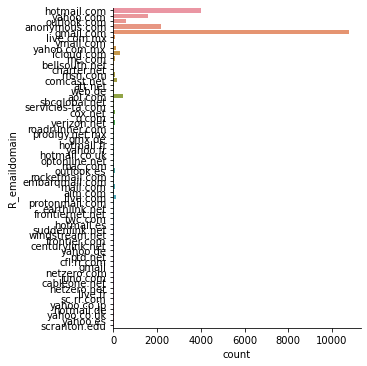

In [82]:
print(train_imputed['R_emaildomain'].value_counts(dropna=False))
sns.catplot(y='R_emaildomain',kind='count',data=train_imputed)

NotFound    19666
Found        2970
Name: id_12, dtype: int64


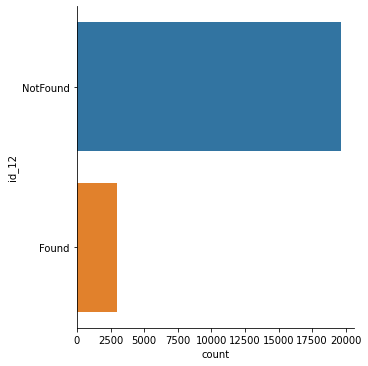

In [83]:
print(train_imputed['id_12'].value_counts(dropna=False))
sns.catplot(y='id_12',kind='count',data=train_imputed)

Found      12213
New         8061
Unknown     2011
NaN          351
Name: id_15, dtype: int64


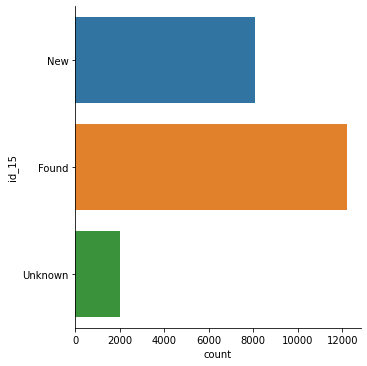

In [84]:
print(train_imputed['id_15'].value_counts(dropna=False))
sns.catplot(y='id_15',kind='count',data=train_imputed)

Found       12088
NotFound     8186
NaN          2362
Name: id_16, dtype: int64


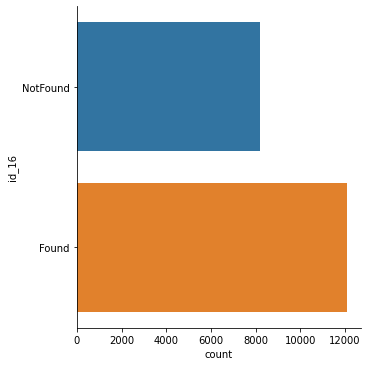

In [85]:
print(train_imputed['id_16'].value_counts(dropna=False))
sns.catplot(y='id_16',kind='count',data=train_imputed)

Found    13627
New       8653
NaN        356
Name: id_28, dtype: int64


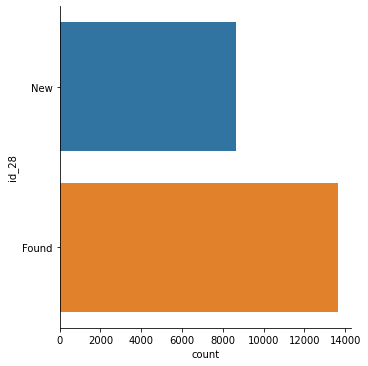

In [86]:
print(train_imputed['id_28'].value_counts(dropna=False))
sns.catplot(y='id_28',kind='count',data=train_imputed)

Found       13510
NotFound     8770
NaN           356
Name: id_29, dtype: int64


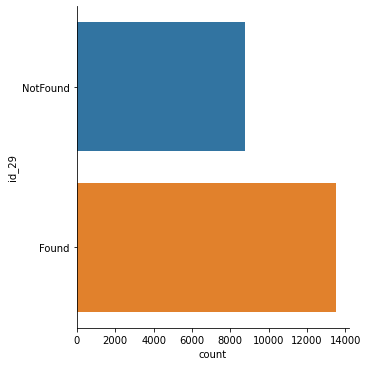

In [87]:
print(train_imputed['id_29'].value_counts(dropna=False))
sns.catplot(y='id_29',kind='count',data=train_imputed)

chrome 63.0                       3226
mobile safari generic             2022
mobile safari 11.0                1954
chrome 65.0                       1185
chrome 64.0                       1124
chrome generic                    1120
chrome 63.0 for android           1116
safari generic                     931
ie 11.0 for desktop                905
chrome 62.0                        866
chrome 64.0 for android            762
chrome 65.0 for android            744
chrome 66.0                        716
chrome 66.0 for android            475
edge 16.0                          474
firefox 57.0                       472
NaN                                452
mobile safari 10.0                 342
chrome 62.0 for android            335
chrome generic for android         215
firefox                            200
edge 15.0                          190
firefox 59.0                       172
samsung browser 6.2                165
firefox 58.0                       139
chrome 61.0 for android  

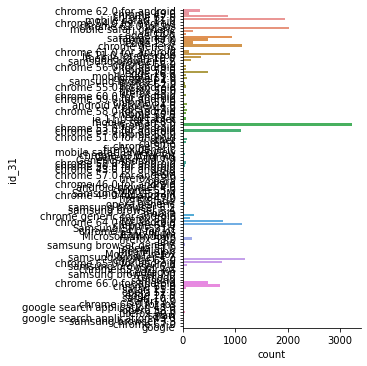

In [88]:
print(train_imputed['id_31'].value_counts(dropna=False))
sns.catplot(y='id_31',kind='count',data=train_imputed)

F      12472
T       9813
NaN      351
Name: id_35, dtype: int64


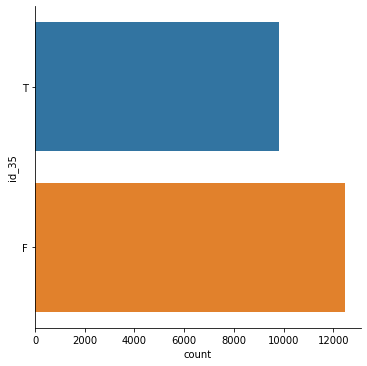

In [89]:
print(train_imputed['id_35'].value_counts(dropna=False))
sns.catplot(y='id_35',kind='count',data=train_imputed)

F      21485
T        800
NaN      351
Name: id_36, dtype: int64


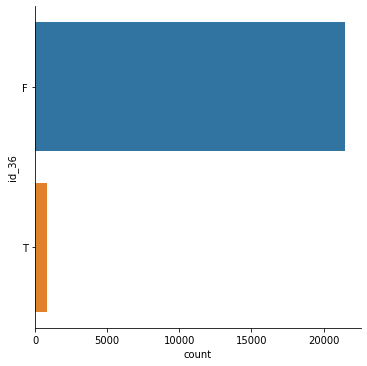

In [90]:
print(train_imputed['id_36'].value_counts(dropna=False))
sns.catplot(y='id_36',kind='count',data=train_imputed)

T      17779
F       4506
NaN      351
Name: id_37, dtype: int64


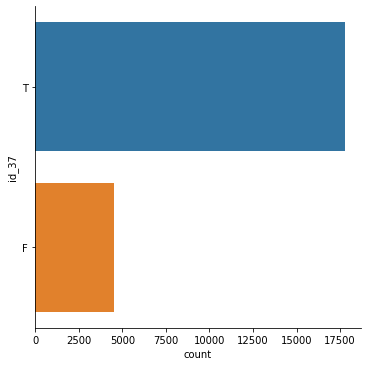

In [91]:
print(train_imputed['id_37'].value_counts(dropna=False))
sns.catplot(y='id_37',kind='count',data=train_imputed)

F      12889
T       9396
NaN      351
Name: id_38, dtype: int64


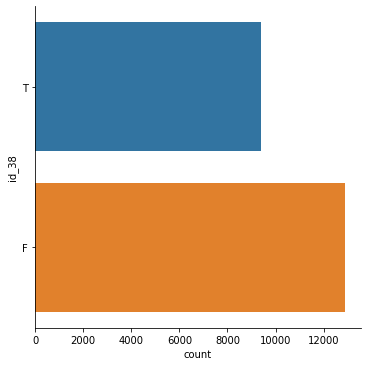

In [92]:
print(train_imputed['id_38'].value_counts(dropna=False))
sns.catplot(y='id_38',kind='count',data=train_imputed)

desktop    12283
mobile      9974
NaN          379
Name: DeviceType, dtype: int64


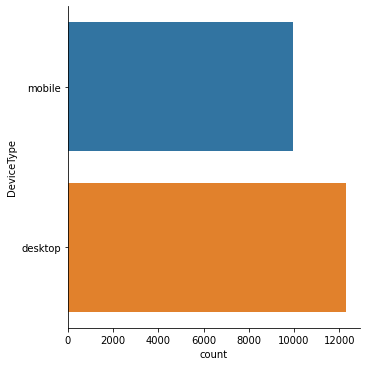

In [93]:
print(train_imputed['DeviceType'].value_counts(dropna=False))
sns.catplot(y='DeviceType',kind='count',data=train_imputed)

**Logistic Regression avec les features numerique**

In [94]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [95]:
train1=train_imputed.drop(['ProductCD','card4','card6','P_emaildomain','R_emaildomain', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37','id_38','DeviceType'],axis=1)
Y_train=train1['isFraud'].astype('int')
X_train=train1.drop('isFraud',axis=1)
scaler=preprocessing.StandardScaler()
X_train_st=scaler.fit_transform(X_train)


In [96]:
logit=LogisticRegression(C=31,random_state=42)
cv_scores = cross_val_score(logit, X_train_st, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()

0.8417237844378189

**Feature importance**

Feature: TransactionID Score: 5.13571
Feature: TransactionDT Score: -4.73649
Feature: TransactionAmt Score: 0.44491
Feature: card1 Score: -0.12227
Feature: card2 Score: -0.13950
Feature: card3 Score: 0.29094
Feature: card5 Score: -0.05996
Feature: C1 Score: -2.67168
Feature: C2 Score: 1.87151
Feature: C3 Score: -0.88956
Feature: C4 Score: 1.57954
Feature: C5 Score: 0.00000
Feature: C6 Score: 0.61091
Feature: C7 Score: -4.45772
Feature: C8 Score: 4.05237
Feature: C9 Score: 0.00000
Feature: C10 Score: 3.94844
Feature: C11 Score: 5.42953
Feature: C12 Score: -1.12837
Feature: C13 Score: -3.12566
Feature: C14 Score: -6.26426
Feature: D1 Score: -0.29176
Feature: V95 Score: 0.09541
Feature: V96 Score: -0.08863
Feature: V97 Score: -0.20905
Feature: V98 Score: -0.10479
Feature: V99 Score: 0.43123
Feature: V100 Score: 0.20449
Feature: V101 Score: 0.15381
Feature: V102 Score: 0.00543
Feature: V103 Score: -0.20833
Feature: V104 Score: -0.16974
Feature: V105 Score: -0.95266
Feature: V106 Score: 0.5

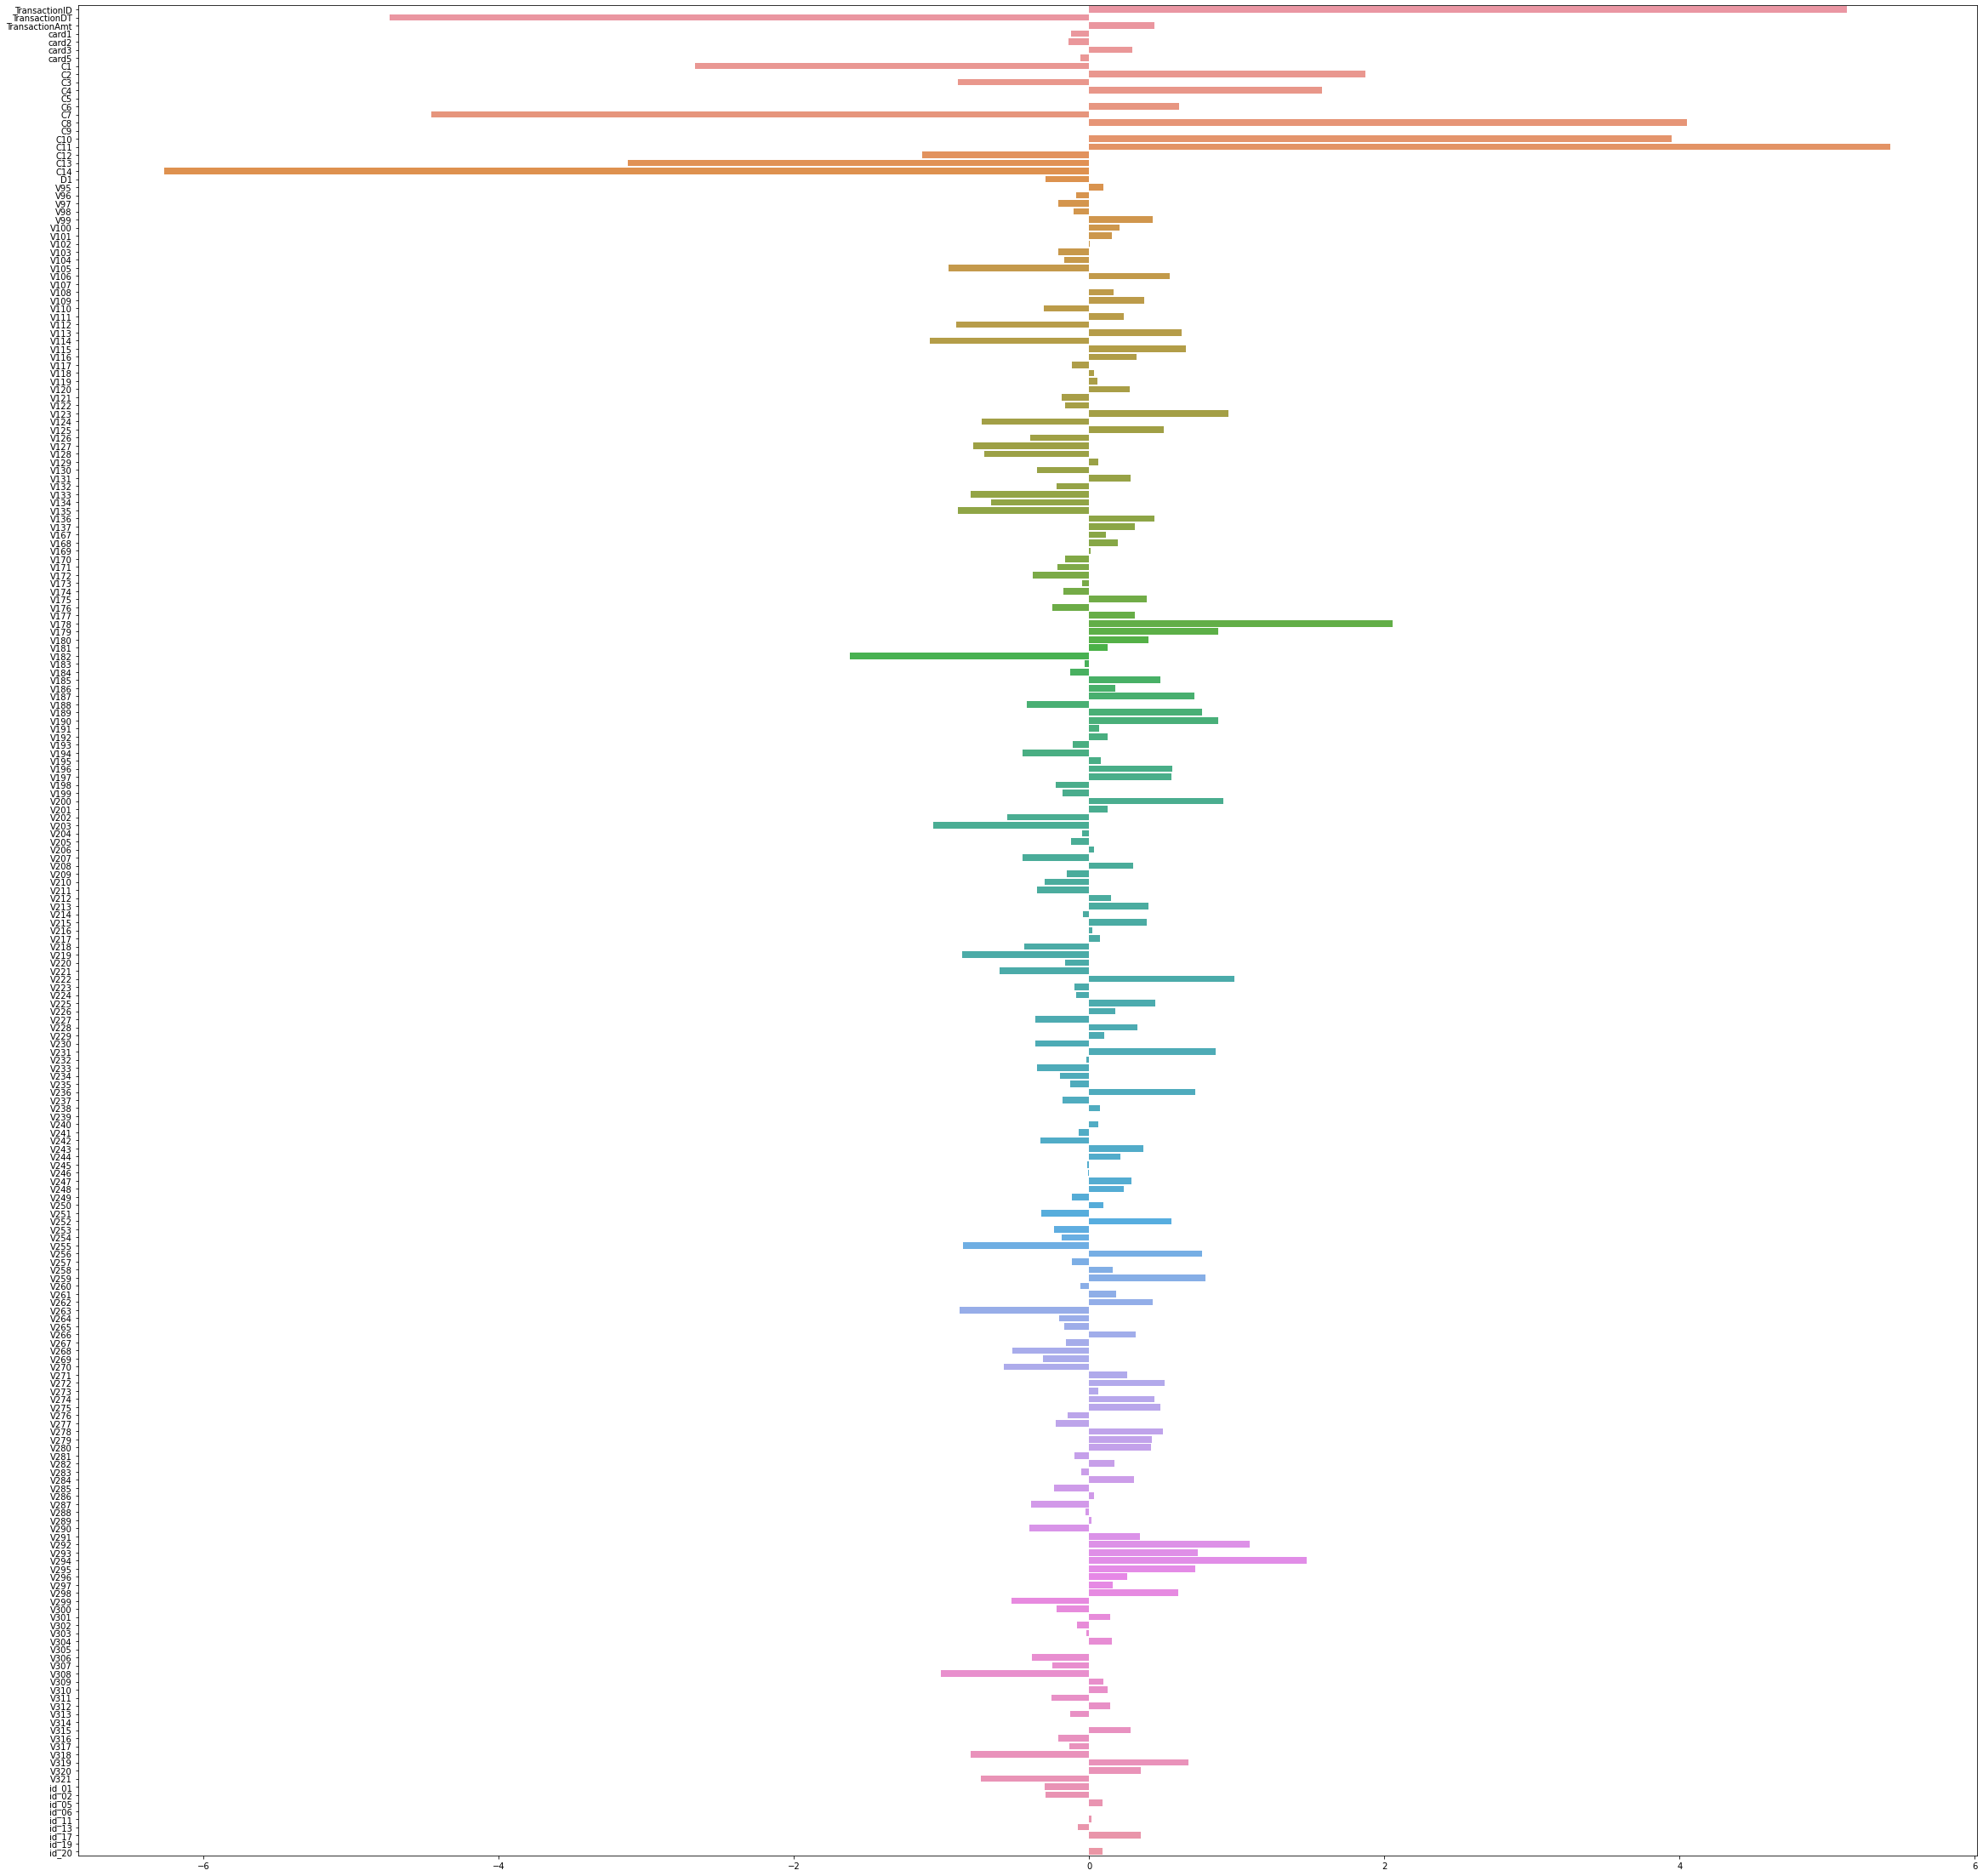

In [97]:
logit.fit(X_train_st,Y_train)
importance = logit.coef_[0]
imp=np.zeros(len(importance))
#summarize feature importance
for i,v in enumerate(importance):
	print('Feature:',list(X_train.columns)[i],'Score: %.5f' % (v))
#plot feature importance
for i,v in enumerate(importance):
  imp[i]='%.5f' % (v)
fig_dims = (40, 40)
fig, ax = plt.subplots(figsize=fig_dims) 
ax = sns.barplot(x=imp, y=list(X_train.columns),ax=ax)

**recrusive feature elimination using cross validation (RFECV)**

In [98]:
from sklearn.feature_selection import RFECV 
rfecv=RFECV(estimator=logit,step=1,scoring="neg_mean_squared_error")
rfecv.fit(X_train_st,Y_train)
rfecv.transform(X_train_st)

array([[-1.57917516, -1.43328488,  0.12786224, ..., -0.89348967,
        -0.98717676,  0.78614056],
       [-1.57916941, -1.43328382, -0.58699464, ...,  0.041397  ,
        -0.98717676,  0.79978228],
       [-1.57905438, -1.43321081, -0.34870901, ..., -0.6045247 ,
        -0.98717676, -0.9599985 ],
       ...,
       [ 1.81631706,  1.91299499, -0.26757752, ...,  0.39835372,
         0.92323082,  1.20903362],
       [ 1.81642634,  1.9130631 ,  0.12786224, ...,  0.39835372,
        -0.98717676, -1.03502791],
       [ 1.81660463,  1.91320251,  1.55757599, ..., -1.7263887 ,
        -0.98717676, -0.57803058]])

In [99]:
rfecv.n_features_#Number of best features

184

In [100]:
rfecv.ranking_

array([ 1,  1,  1,  1,  1,  1,  6,  1,  1,  1,  1, 43,  1,  1,  1, 44,  1,
        1,  1,  1,  1,  1,  8, 20,  1,  1,  1,  1,  1, 34,  1,  1,  1,  1,
       45,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4, 36,  5,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 17,
        1,  1,  1, 32,  1,  1,  1,  1,  1,  1,  1, 10,  1, 25, 27,  1,  1,
        1,  1,  1,  1,  1,  1,  9,  1,  7,  1,  1,  1,  1,  1,  1,  1,  1,
       23, 13, 29,  1,  1,  1,  1,  1,  1,  1, 31,  1, 21, 35,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, 18,  1,  1, 37,  1,  1, 11,  1,  1,
       19, 33,  3,  2,  1,  1,  1, 38, 39,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 26,  1,  1, 30,  1, 24,
       14,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 22,  1, 46,
        1,  1,  1, 16, 15,  1,  1,  1, 41,  1,  1, 12,  1,  1,  1,  1,  1,
        1,  1, 42, 28,  1

In [101]:
rfecv.support_#which features to keep 

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
        True,  True,  True,  True, False,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,

In [102]:
pp=[]
for i in range(len(rfecv.support_)):
  if rfecv.support_[i]==False:
    pp.append(list(X_train.columns)[i])
X_train1=X_train.drop(pp,axis=1)
scaler=preprocessing.StandardScaler()
X_train_st1=scaler.fit_transform(X_train1)
logit=LogisticRegression(C=31,random_state=42)
cv_scores = cross_val_score(logit, X_train_st1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score augmente


0.8479267212755361

**Removing irrelevant features**

In [103]:
#il faut q'on fixe un thresh hold q
l1=[]#liste des features sans imporatnace
for i in range(len(imp)):
  if imp[i]==0:
    l1.append(list(X_train.columns)[i])
X_train1=X_train.drop(l1,axis=1)
scaler=preprocessing.StandardScaler()
X_train_st1=scaler.fit_transform(X_train1)
logit=LogisticRegression(C=31,random_state=42)
cv_scores = cross_val_score(logit, X_train_st1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score reste le meme

0.8417238234741523

**Logistic Regression avec toutes les features**

In [111]:
sites = ['ProductCD','card4','card6','P_emaildomain','R_emaildomain', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37','id_38','DeviceType']
train1=train_imputed.drop(sites,axis=1)
Y_train=train1['isFraud'].astype('int')
X_train=train1.drop('isFraud',axis=1)
X1_train=pd.merge(X_train,pd.get_dummies(train_imputed[sites]),right_index=True,left_index=True)
scaler=preprocessing.StandardScaler()
X_train_st=scaler.fit_transform(X_train)
X0_train=pd.merge(pd.DataFrame(X_train_st),pd.get_dummies(train_imputed[sites]),right_index=True,left_index=True)

In [112]:
logit=LogisticRegression(C=1,random_state=42)
cv_scores = cross_val_score(logit, X0_train, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()

0.8415099504724382

**Feature importance**

Feature: TransactionID Score: 2.28412
Feature: TransactionDT Score: -1.86182
Feature: TransactionAmt Score: 0.63631
Feature: card1 Score: -0.10256
Feature: card2 Score: -0.15842
Feature: card3 Score: 0.29442
Feature: card5 Score: -0.04320
Feature: C1 Score: -1.87688
Feature: C2 Score: 1.86153
Feature: C3 Score: -0.96776
Feature: C4 Score: 0.79390
Feature: C5 Score: 0.00000
Feature: C6 Score: 0.66349
Feature: C7 Score: -2.63299
Feature: C8 Score: 2.35784
Feature: C9 Score: 0.00000
Feature: C10 Score: 2.03358
Feature: C11 Score: 3.19064
Feature: C12 Score: -0.43107
Feature: C13 Score: -2.27080
Feature: C14 Score: -3.70630
Feature: D1 Score: -0.28438
Feature: V95 Score: -0.05674
Feature: V96 Score: 0.04334
Feature: V97 Score: -0.04729
Feature: V98 Score: -0.09294
Feature: V99 Score: 0.38280
Feature: V100 Score: 0.06946
Feature: V101 Score: -0.03152
Feature: V102 Score: 0.08231
Feature: V103 Score: -0.04050
Feature: V104 Score: -0.13092
Feature: V105 Score: -0.42597
Feature: V106 Score: 0.

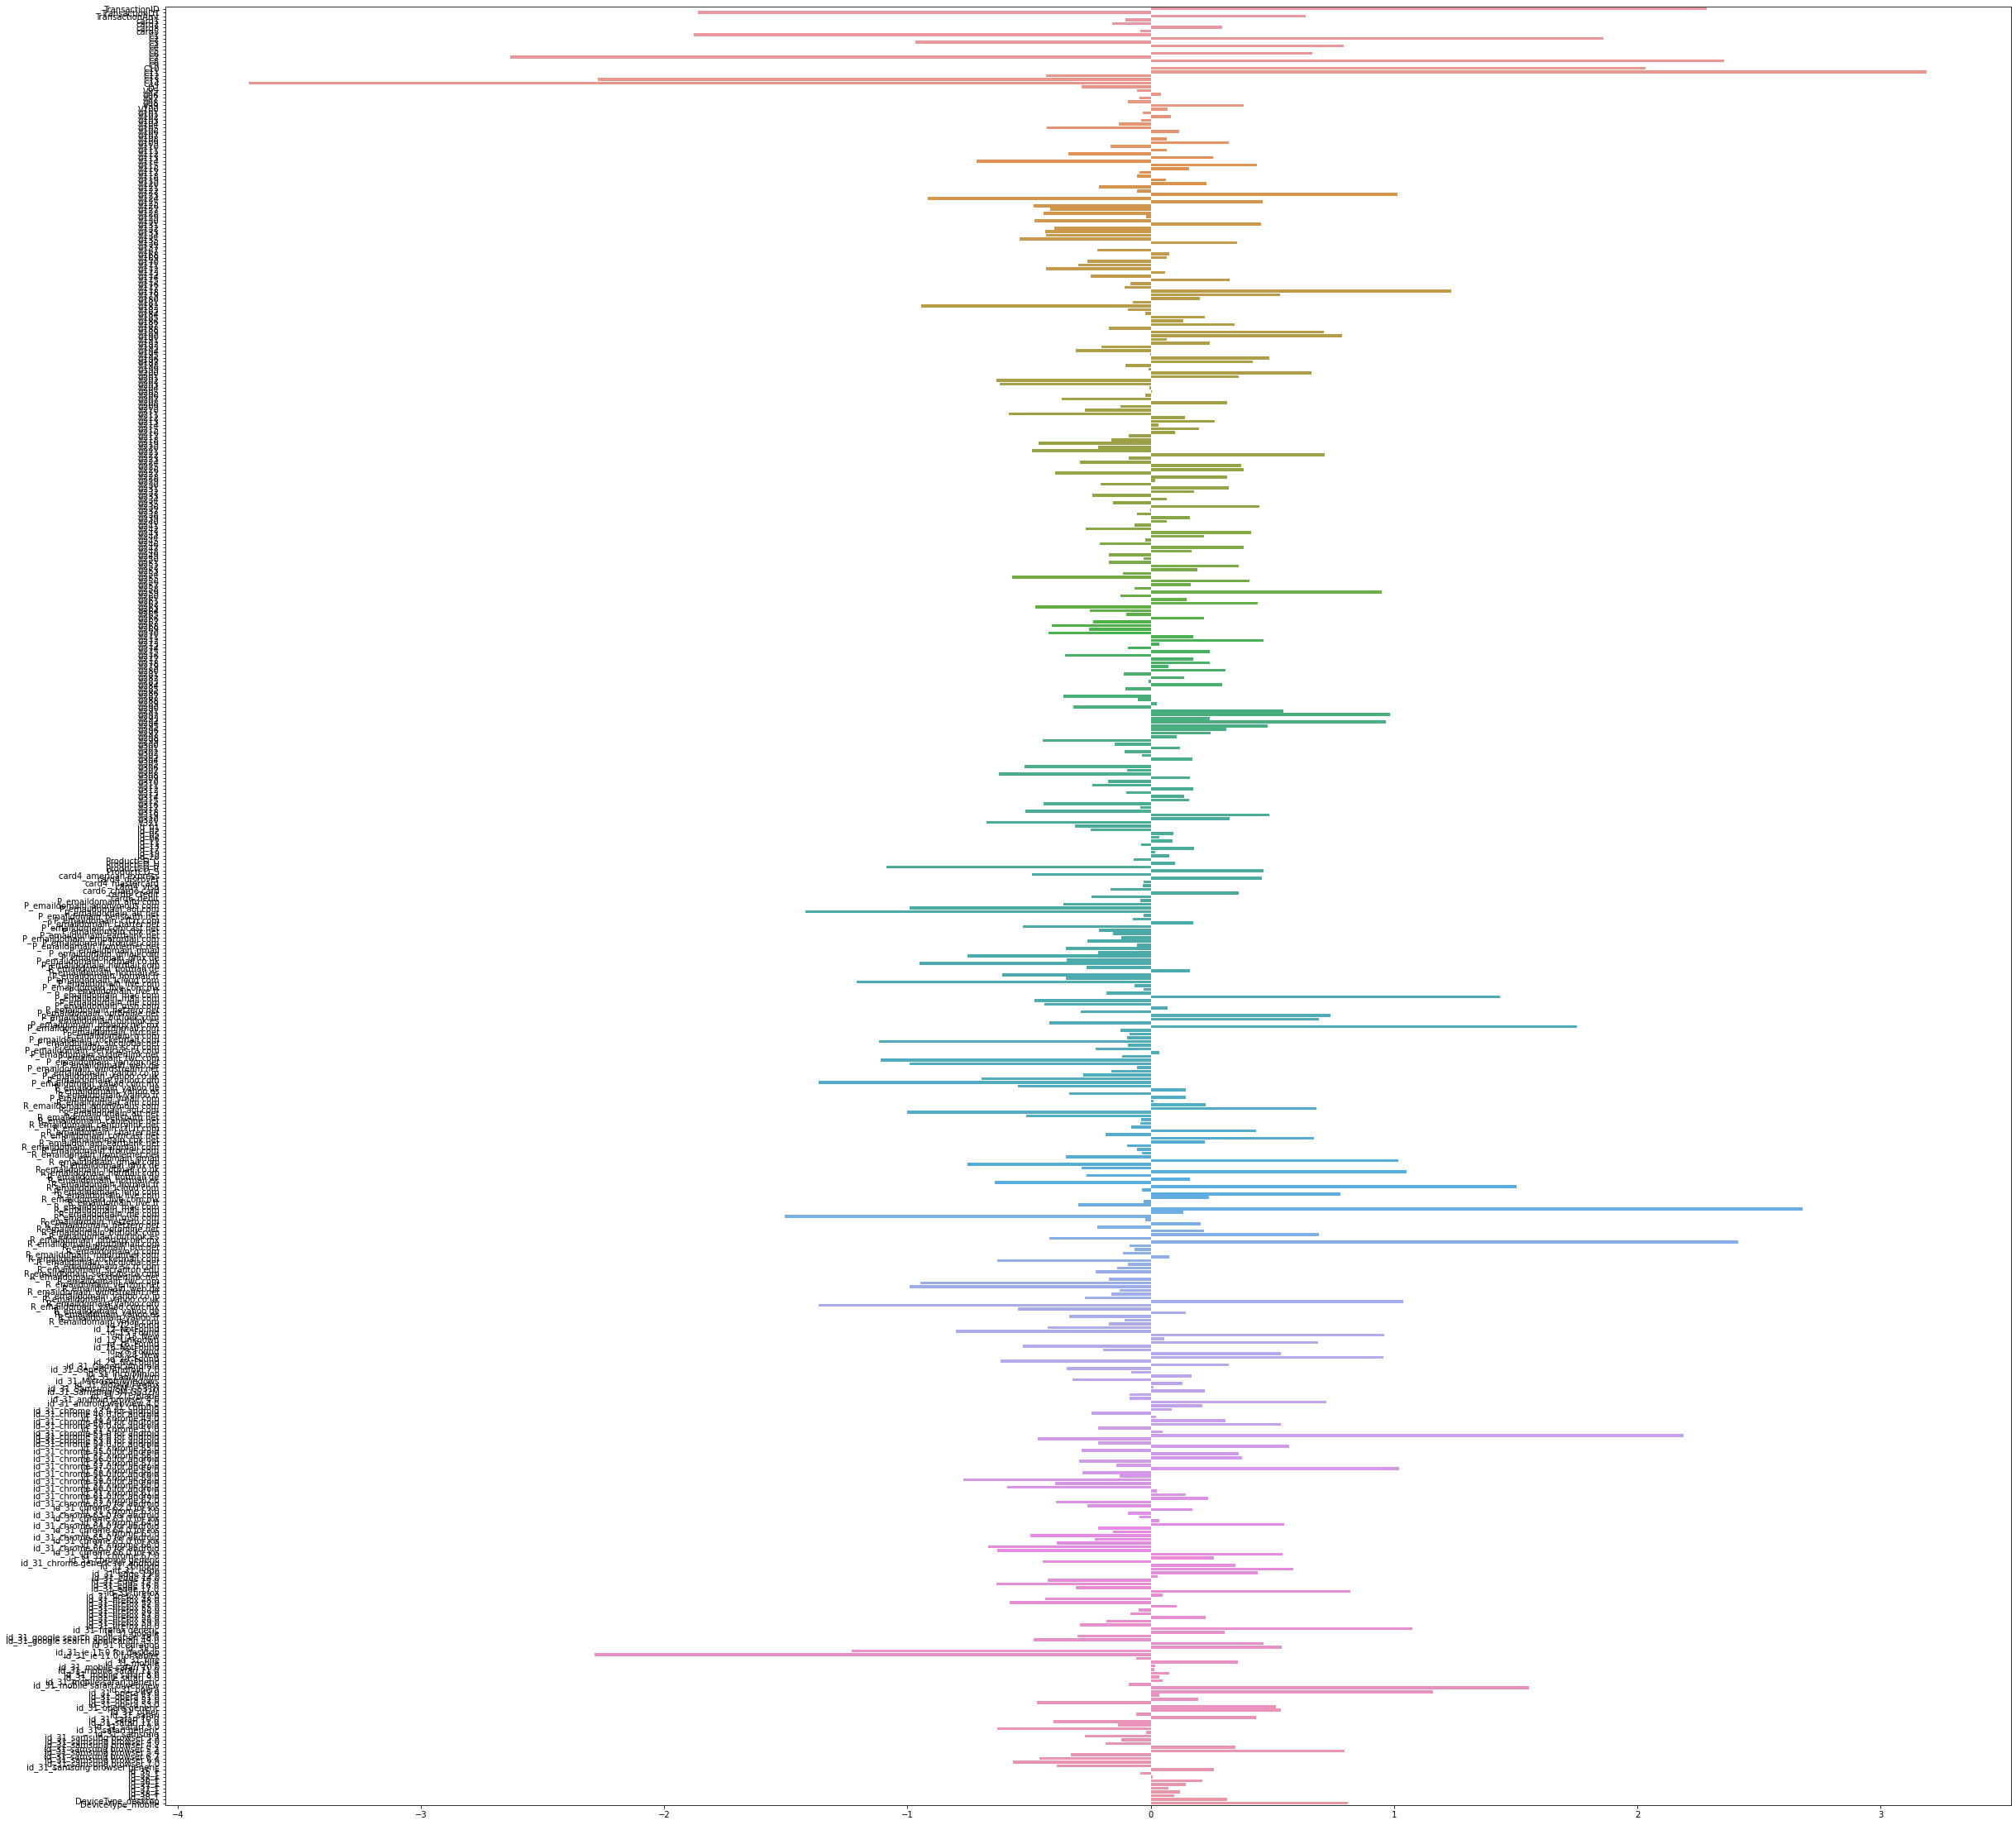

In [113]:
logit.fit(X0_train,Y_train)
importance = logit.coef_[0]
imp=np.zeros(len(importance))
#summarize feature importance
for i,v in enumerate(importance):
	print('Feature:',list(X1_train.columns)[i],'Score: %.5f' % (v))
#plot feature importance
for i,v in enumerate(importance):
  imp[i]='%.5f' % (v)
fig_dims = (40, 40)
fig, ax = plt.subplots(figsize=fig_dims) 
ax = sns.barplot(x=imp, y=list(X1_train.columns),ax=ax)

**recrusive feature elimination using cross validation (RFECV)**

In [114]:
from sklearn.feature_selection import RFECV 
rfecv=RFECV(estimator=logit,step=1,scoring="neg_mean_squared_error")
rfecv.fit(X0_train,Y_train)
rfecv.transform(X0_train)

array([[-1.57917516, -1.43328488,  0.12786224, ...,  0.        ,
         0.        ,  1.        ],
       [-1.57916941, -1.43328382, -0.58699464, ...,  0.        ,
         1.        ,  0.        ],
       [-1.57905438, -1.43321081, -0.34870901, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.81631706,  1.91299499, -0.26757752, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.81642634,  1.9130631 ,  0.12786224, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.81660463,  1.91320251,  1.55757599, ...,  0.        ,
         0.        ,  1.        ]])

In [115]:
rfecv.n_features_

267

In [116]:
rfecv.ranking_

array([  1,   1,   1, 111,  24,   1, 168,   1,   1,   1,   1, 215,   1,
         1,   1, 217,   1,   1,   1,   1,   1,   1, 159, 170, 138, 103,
         1, 139, 193, 137, 150,  65,   1, 131, 218,   7,   1,   1, 122,
         1,   1,   6,   8,  42, 146, 175, 174,  44,  43, 173,   1,   1,
         1,   1,   1,   1, 188,   1,   1,   1,   1,   1,   1,   1, 207,
         1, 156, 181,   1,   1,   1, 163,   1,   1,  89, 141,   1,   1,
        19, 142,   1, 158, 125,   1, 140,   1,   1,   1,   1, 101,  53,
        54,  11, 206,   1,   1,   1, 178,   1,   1,   1,   1, 211, 213,
       194,   1,   1,  52,   1,   1, 151,  61, 143,   1, 124, 169,  92,
         1,   1,   1,   1,  80,   2,   1,   1,   1,  79, 204,  78,   1,
        26,  10, 179,  87,   1, 208, 189,  88, 128, 129,   4,   3,   1,
       183,  86,  27,   1,  29, 200,   1,   1,  98,   1,   1,   1, 107,
       160,   1,  95, 106,   1,  46,   1, 145,  47,  94,  32,   1,   1,
         5,   1, 171,  93,  31,   1,   1,  77, 102,   1,  85,  8

In [117]:
rfecv.support_#which features to keep 

array([ True,  True,  True, False, False,  True, False,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
        True,  True, False,  True,  True, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True, False,  True, False, False,  True,  True,  True, False,
        True,  True, False, False,  True,  True, False, False,  True,
       False, False,  True, False,  True,  True,  True,  True, False,
       False, False, False, False,  True,  True,  True, False,  True,
        True,  True,  True, False, False, False,  True,  True, False,
        True,  True, False, False, False,  True, False, False, False,
        True,  True,  True,  True, False, False,  True,  True,  True,
       False, False,

In [118]:
pp=[]
for i in range(len(rfecv.support_)):
  if rfecv.support_[i]==False:
    pp.append(list(X0_train.columns)[i])
X3_train=X0_train.drop(pp,axis=1)
logit=LogisticRegression(C=1,random_state=42)
cv_scores = cross_val_score(logit, X3_train, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score augmente

0.8753978672937857

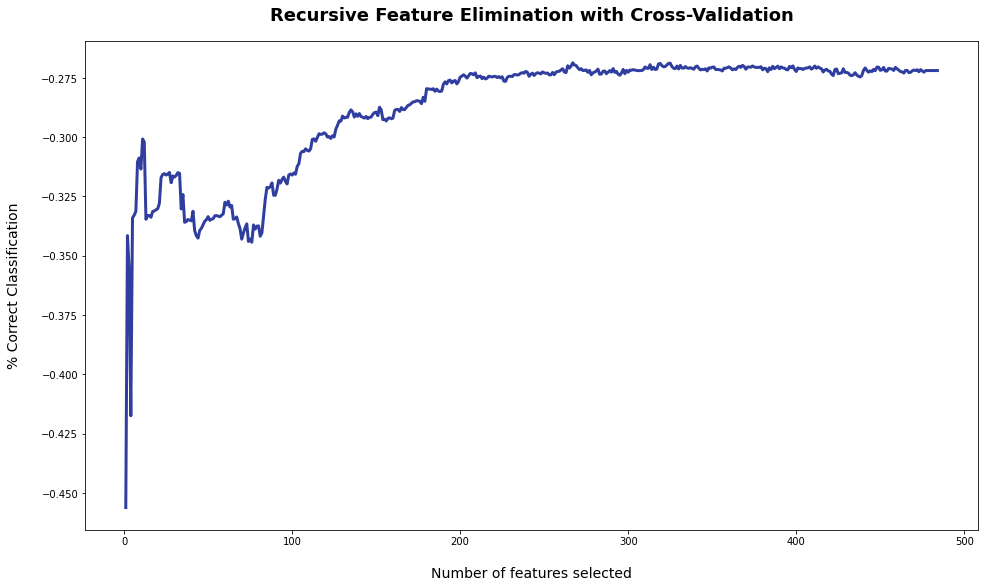

In [119]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()